# Advance Lane Finding Project

The goal of this project is to identify lane boundaries in a video from a front facing camera on a car.

To achieve this we will go through the following steps:

* Camera calibration
* Un-distortion of the images (based on camera calibration)
* Thresholding of image (based on gradients)
* Perspective transform to a top down image space
* Identification of the left and right lane marking through windowing
* Fitting curved lines to left and right lane marking
* Perspective transform back to un-distorted image frame
* Annotation of image with statistics about road curvature

## Camera Calibration

In this section we will calculate our camera calibration using a collection of test images.

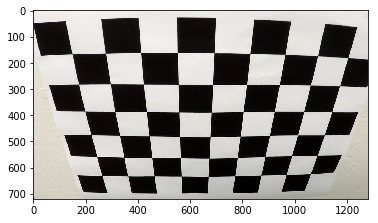

In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Calibration image properties
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Show example calibration image
fname = 'camera_cal/calibration2.jpg'
img = mpimg.imread(fname)

plt.imshow(img)

The following cell iterates through all calibration images attempting to find the internal corners in each image. 

If it finds them then they are added to a collection of image points with the corresponding object points added (we know that the squares in the image would be square for a perfectly calibrated camera - once perspective has been corrected for)

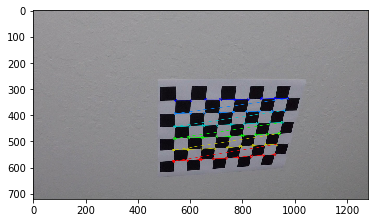

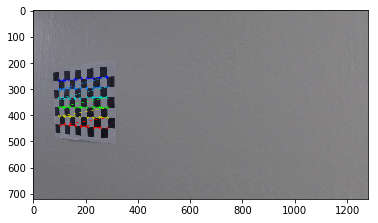

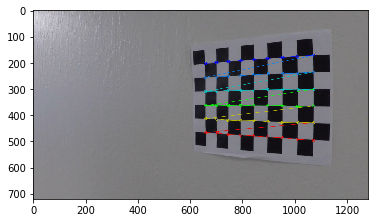

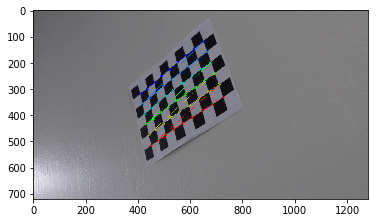

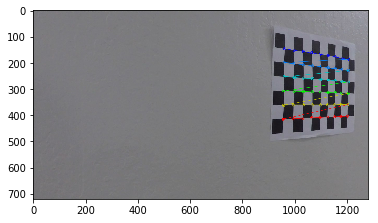

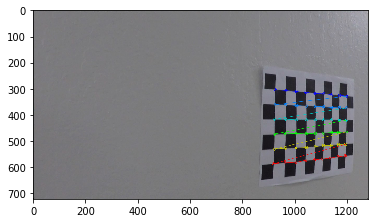

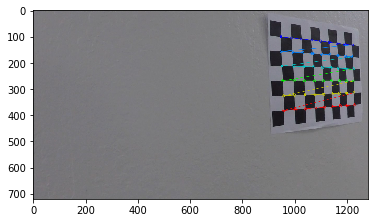

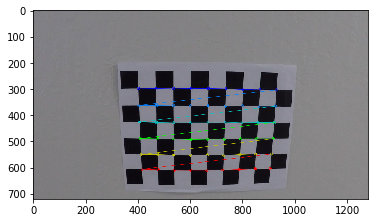

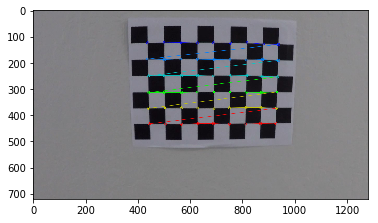

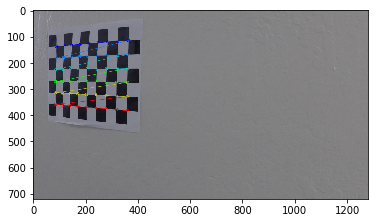

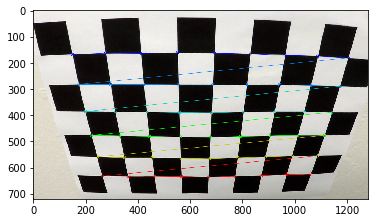

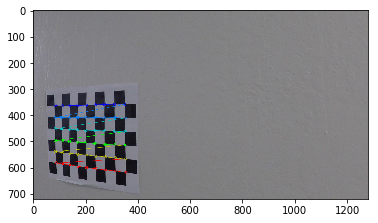

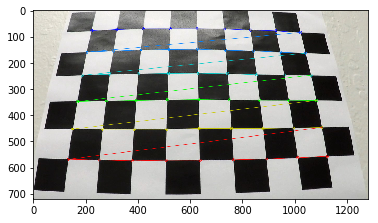

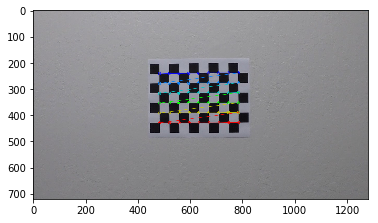

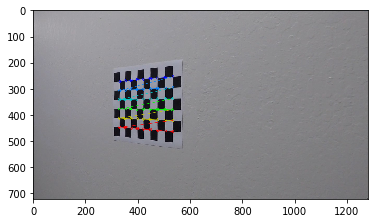

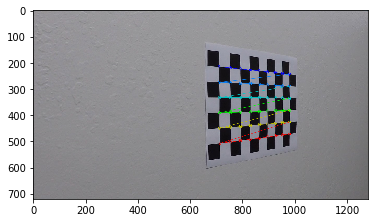

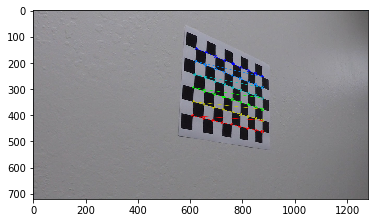

In [2]:
import glob

# List all calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the calibration images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # (x,y) coordinates

for fname in images:
    
    # Read in calibration image
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Add detected object and image points
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure()
        plt.imshow(img)

Now that we have a mapping from object points to image points for multiple calibration images we can calibrate our camera. This outputs the following parameters:

* mtx - Camera matrix
* dist - Distortion coefficients
* rvecs - Rotation vectors (position of camera in world)
* tvecs - Translation vectors (position of camera in world)

We then use the camera matrix and distortion coefficients to un-distort an image.

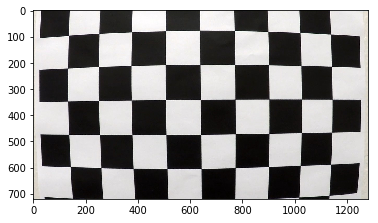

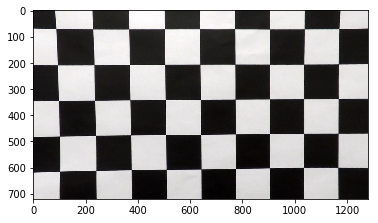

In [3]:
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

def cal_undistort(img, mtx, dist):
    
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

# Show example of distorted and undistorted images
img = mpimg.imread('camera_cal/calibration1.jpg')
undist = cal_undistort(img, mtx, dist)

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(undist)

mpimg.imsave('output_images/undistorted.jpg', undist)

## Thresholding

This section covers a number of techniques used to find lines in the image:

* Sobel x/y/magnitude/direction
* Colour mapping (Grayscale, RGB, HLS)
* Combination of the above

First we will look at Sobel thresholding.

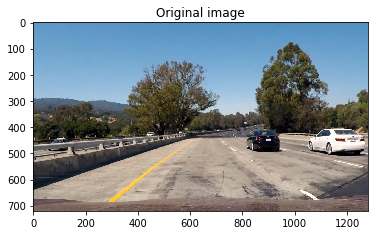

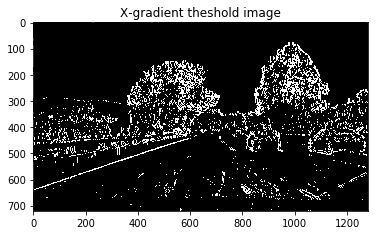

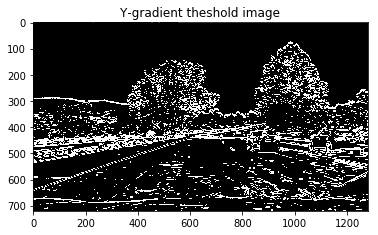

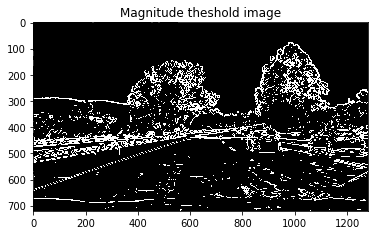

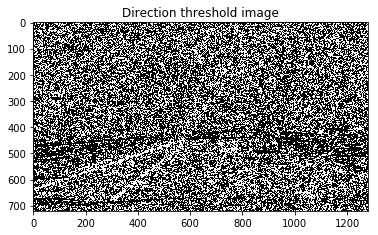

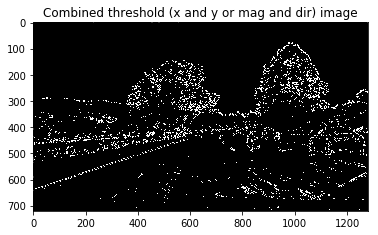

In [4]:
# Calculate derivatives from image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate sobel in either x or y direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take absolute of gradient
    abs_sobel = np.absolute(sobel)
    
    # scale value from 0 to 255
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create binary image based on thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate magnitude of gradient (scaled between 0 and 255)
    mag_grad = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag_grad = np.uint8(255 * mag_grad / np.max(mag_grad))
    
    # Create binary image based on thresholds
    binary_output = np.zeros_like(scaled_mag_grad)
    binary_output[(scaled_mag_grad >= thresh[0]) & (scaled_mag_grad <= thresh[1])] = 1
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take absolute of gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculate angle of gradient
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create binary image based on thresholds
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return binary_output

# Size of Sobel kernel to use
ksize = 11

# Examples of thresholding results
img = mpimg.imread('test_images/test1.jpg')
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20,100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20,100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30,100))
dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.7,1.3))

plt.figure()
plt.title('Original image')
plt.imshow(img)

plt.figure()
plt.title('X-gradient theshold image')
plt.imshow(gradx, cmap='gray')

plt.figure()
plt.title('Y-gradient theshold image')
plt.imshow(grady, cmap='gray')

plt.figure()
plt.title('Magnitude theshold image')
plt.imshow(mag_binary, cmap='gray')
                     
plt.figure()
plt.title('Direction threshold image')
plt.imshow(dir_binary, cmap='gray')

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure()
plt.title('Combined threshold (x and y or mag and dir) image')
plt.imshow(combined, cmap='gray')


Now we will look at colour mappings and thresholding based on individual channels.

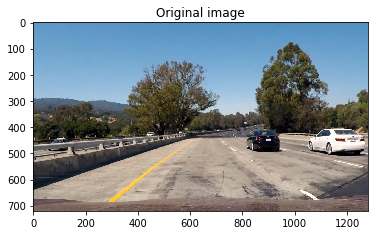

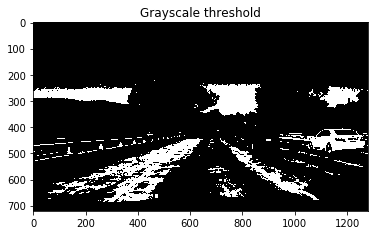

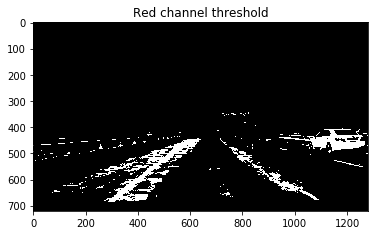

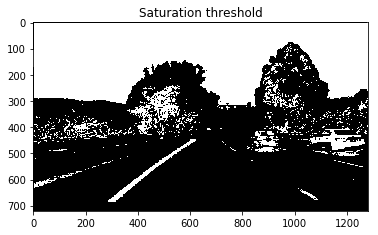

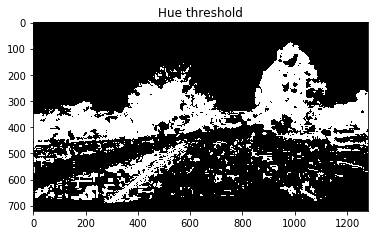

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def gray_threshold(img, thresh=(180, 255)):
    # Convert to grayscale colour space
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply threshold
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    
    return binary
    
def red_threshold(img, thresh=(200, 255)):
    # Extract red component
    R = img[:,:,0]
    
    # Apply threshold
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    return binary

def saturation_threshold(img, thresh=(90, 255)):
    # Convert to HLS colour space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Extract saturation component
    S = hls[:,:,2]
    
    # Apply threshold
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def hue_threshold(img, thresh=(15, 100)):
    # Convert to HLS colour space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Extract hue component
    H = hls[:,:,0]
    
    # Apply threshold
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    return binary

# Examples of threshold detection
img = mpimg.imread('test_images/test1.jpg')

plt.figure()
plt.title('Original image')
plt.imshow(img)

binary = gray_threshold(img, thresh=(180, 255))

plt.figure()
plt.title('Grayscale threshold')
plt.imshow(binary, cmap='gray')

binary = red_threshold(img, thresh=(200, 255))

plt.figure()
plt.title('Red channel threshold')
plt.imshow(binary, cmap='gray')

binary = saturation_threshold(img, thresh=(90, 255))

plt.figure()
plt.title('Saturation threshold')
plt.imshow(binary, cmap='gray')

binary = hue_threshold(img, thresh=(15, 100))

plt.figure()
plt.title('Hue threshold')
plt.imshow(binary, cmap='gray')

Now we look at combining the gradient and colour threshold techniques

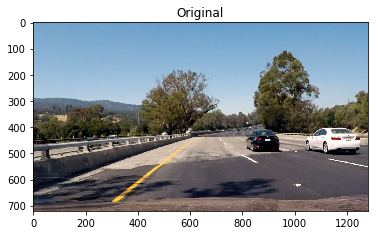

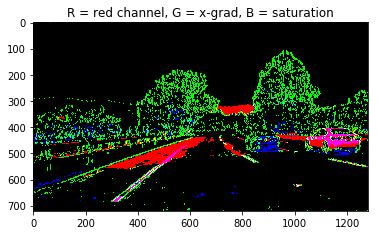

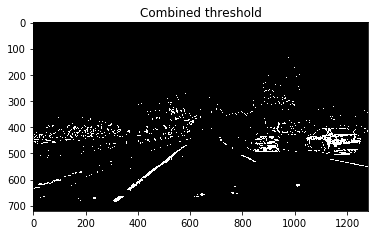

In [6]:
def combined_threshold(img, plot=False):

    # Combine line detection methods
    r_binary = red_threshold(img, thresh=(200, 255))
    sx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=11, thresh=(20,100))
    s_binary = saturation_threshold(img, thresh=(170,255))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | ((sx_binary == 1) & (r_binary == 1))] = 1

    if(plot):
        
        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = 255 * np.dstack(( r_binary, sx_binary, s_binary))

        plt.figure()
        plt.title('R = red channel, G = x-grad, B = saturation')
        plt.imshow(color_binary)
    
    return combined_binary

img = mpimg.imread('test_images/test4.jpg')

plt.figure()
plt.title('Original')
plt.imshow(img)

combined_binary = combined_threshold(img, plot=True)

plt.figure()
plt.title('Combined threshold')
plt.imshow(combined_binary, cmap='gray')

## Perspective Transform

The following code defines the methods required to perform a perspective transform on our images. There is a function to convert from undistorted image to top down image and a function to convert back to the undistorted image

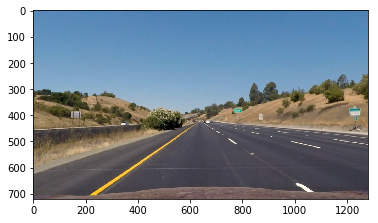

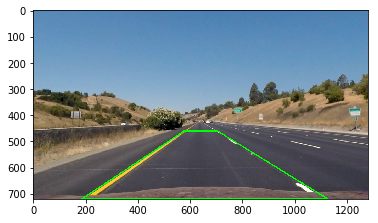

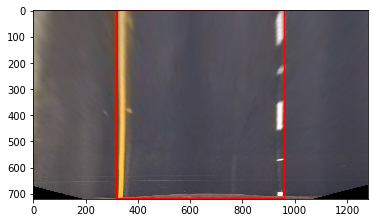

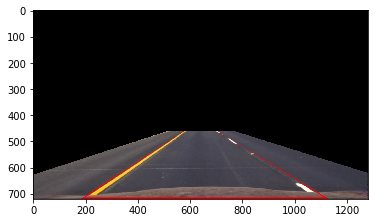

In [7]:
# Four source coordinates taken from our image pixels
src = np.float32(
    [[578, 460],
     [185, 720],
     [1127, 720],
     [704, 460]])

# Four desired coordinates to produce a top down image
dst = np.float32(
    [[320, 0],
     [320, 720],
     [960, 720],
     [960, 0]])

def perspective_transform():
    return cv2.getPerspectiveTransform(src, dst)

def inv_perspective_transform():
    return cv2.getPerspectiveTransform(dst, src)
        
def warp(img, show_points=False):
    
    M = perspective_transform()
    
    img_size = (img.shape[1], img.shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    if(show_points):
        temp = img.copy()
        pts = src.astype(int).reshape(-1,1,2)
        cv2.polylines(temp, [pts], True, (0,255,0), thickness=3)

        plt.figure()
        plt.imshow(temp)
    
        pts = dst.astype(int).reshape(-1,1,2)
        cv2.polylines(warped, [pts], True, (255,0,0), thickness=3)
    
    return warped

def unwarp(img):
    
    Minv = inv_perspective_transform()
    
    img_size = (img.shape[1], img.shape[0])
    
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)

    return unwarped

# Example of perspective transformation
img = mpimg.imread('test_images/straight_lines1.jpg')
undist = cal_undistort(img, mtx, dist)
mpimg.imsave('output_images/undistorted_straight_lines1.jpg', undist)

plt.figure()
plt.imshow(undist)

warped = warp(undist, show_points=True)

plt.figure()
plt.imshow(warped)

unwarped = unwarp(warped)

plt.figure()
plt.imshow(unwarped)

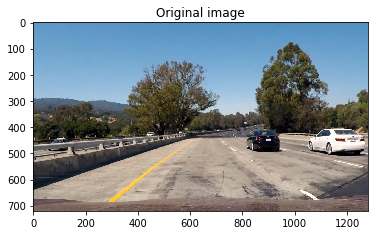

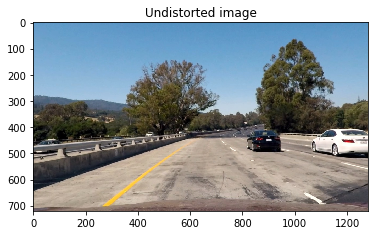

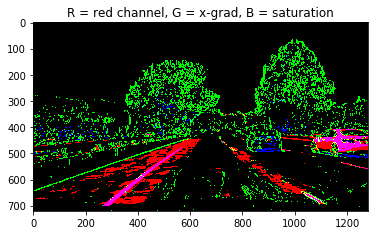

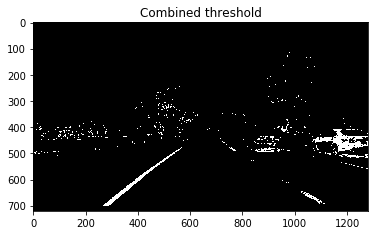

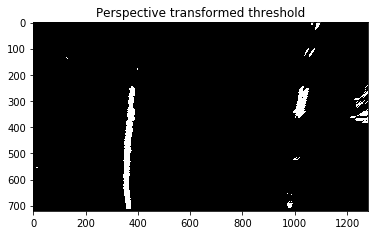

In [8]:
# Pipeline so far

# === Load image ===

img = mpimg.imread('test_images/test1.jpg')

plt.figure()
plt.title('Original image')
plt.imshow(img)

# === Undistort ===

undist = cal_undistort(img, mtx, dist)

plt.figure()
plt.title('Undistorted image')
plt.imshow(undist)

# === Thresholding ===

binary = combined_threshold(undist, plot=True)

plt.figure()
plt.title('Combined threshold')
plt.imshow(binary, cmap='gray')

# Perspective transform
binary_warped = warp(binary)

plt.figure()
plt.title('Perspective transformed threshold')
plt.imshow(binary_warped, cmap='gray')


## Windowing

Next we will apply some form of windowing function to calculate the position of the lane lines. Before applying windowing we will first define a method for calculating the curvature adjusting for the pixel x-y scaling.

In [9]:
# Define a couple of constants based on our perspective transform
xm_per_pix=3.7/700
ym_per_pix=30/720

def curvature(leftx, lefty, rightx, righty, y_max):
    '''
    Calculate curvature of left and right lanes in world frame
    
    leftx, lefty           - x-y coordinates of left lane pixels
    rightx, righty         - x-y coordinates of right lane pixels
    y_max                  - maximum y-coordinate for image
    '''
    
    # Fit polynomial to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_max*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_max*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

Now we can detect the lane lines and work out the curvature of each line.

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def Update(self, detected, x, y, fit, radius_of_curvature):
        self.detected = detected
        self.allx = x
        self.ally = y
        self.current_fit = fit
        self.radius_of_curvature = radius_of_curvature

795.022170018 m 1430.68782829 m


C:\Users\andyk\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


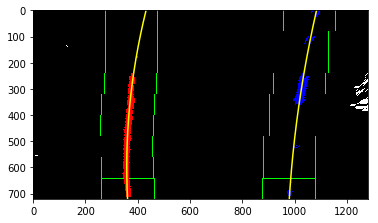

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def window_lanes_init(binary_warped, plot=False, nwindows=9, margin=100, minpix=50, min_points=100):
    '''
    Find lanes using sliding window (without prior estimate for window)
    
    nwindows - number of windows to use moving up through the image
    margin   - half width of each window
    minpix   - minimum number of pixels required for a valid window centre position
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if (plot):
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if (plot):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # check if we have found enough points for line
    found_left = len(lefty) > min_points
    found_right = len(righty) > min_points
    
    # Fit a second order polynomial to each
    if(found_left):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
    
    if(found_right):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
        
    # Calculate curvature of left and right lanes
    y_max = binary_warped.shape[0] - 1
    left_curverad, right_curverad = curvature(leftx, lefty, rightx, righty, y_max)
    
    if(plot):
        # plot left and right pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Plot lane lines with best fit
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    # Create lines to store information
    left = Line()
    left.Update(found_left, leftx, lefty, left_fit, left_curverad)
    
    right = Line()
    right.Update(found_right, rightx, righty, right_fit, right_curverad)
    
    return left, right

# Example of windowing
left, right = window_lanes_init(binary_warped, plot=True)
print(left.radius_of_curvature, 'm', right.radius_of_curvature, 'm')


797.741679139 m 1430.68782829 m


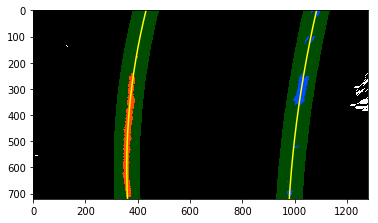

In [12]:
def window_lanes(binary_warped, left, right, margin=50, min_points=100, plot=False):
    
    left_fit = left.current_fit
    right_fit = right.current_fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # check if we have found enough points for line
    found_left = len(lefty) > min_points
    found_right = len(righty) > min_points
    
    # Fit a second order polynomial to each
    if(found_left):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
    
    if(found_right):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
    
    # Calculate curvature of left and right lanes
    y_max = binary_warped.shape[0] - 1
    left_curverad, right_curverad = curvature(leftx, lefty, rightx, righty, y_max)
    
    if(plot):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        plt.figure()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    # Update lines
    left.Update(found_left, leftx, lefty, left_fit, left_curverad)
    right.Update(found_right, rightx, righty, right_fit, right_curverad)
        
    return left, right

# Example left and right lane fit
left, right = window_lanes(binary_warped, left, right, plot=True)
print(left.radius_of_curvature, 'm', right.radius_of_curvature, 'm')

Alternatively we could use convolution to find the lane lines:

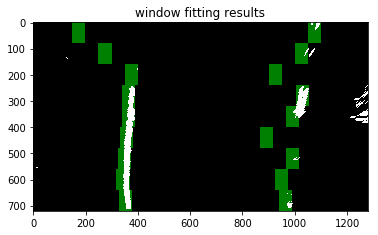

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = 255*binary_warped
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


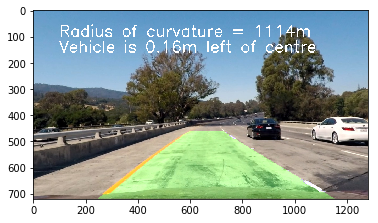

In [14]:
def draw_overlay(binary_warped, undist, left, right):
    
    left_fit = left.current_fit
    left_curverad = left.radius_of_curvature
    leftx = left.allx
    lefty = left.ally
    
    right_fit = right.current_fit
    right_curverad = right.radius_of_curvature
    rightx = right.allx
    righty = right.ally
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Plot left and right pixels
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]

    Minv = inv_perspective_transform()

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate average radius
    avg_curverad = (left_curverad + right_curverad) / 2
    
    # Calculate centre of lane
    lane_centre = (left_fitx[-1] + right_fitx[-1]) / 2
    vehicle_centre = binary_warped.shape[1] / 2
    vehicle_offset = (vehicle_centre - lane_centre) * xm_per_pix

    # TODO: Add text for curvature and position in lane
    textPos = (100, binary_warped.shape[0] - 100)
    cv2.putText(result, 'Radius of curvature = {:0.0f}m'.format(avg_curverad), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255,255), thickness=3)
    cv2.putText(result, 'Vehicle is {0:0.2f}m {1} of centre'.format(abs(vehicle_offset), 'right' if vehicle_offset > 0 else 'left'), (100, 160), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255,255), thickness=3)
    
    return result
    
result = draw_overlay(binary_warped, undist, left, right)
plt.imshow(result)

## Final Pipeline

Here is the final pipeline:

C:\Users\andyk\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


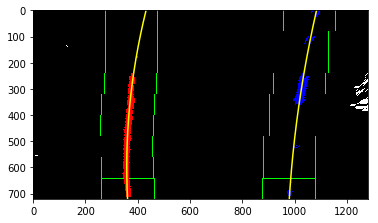

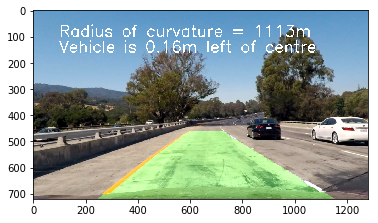

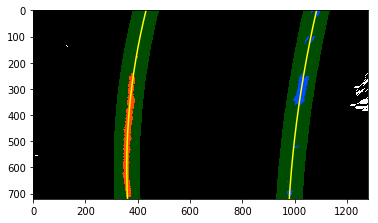

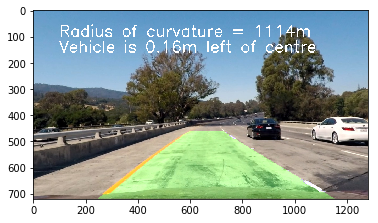

In [15]:
from time import time    

# Complete pipeline
def pipeline(img, left, right, plot=False):
    
    # === Undistort ===
    undist = cal_undistort(img, mtx, dist)

    # === Thresholding ===
    binary = combined_threshold(undist)
    
    # === Perspective transform ===
    binary_warped = warp(binary)
    
    # === Find lane lines ===
    # Switch based on whether we already have an estimate for the lines
    if(left.detected and right.detected):
        left, right = window_lanes(binary_warped, left, right, plot=plot)
    else:
        left, right = window_lanes_init(binary_warped, plot=plot)
    
    # === Render overlay ===
    result = draw_overlay(binary_warped, undist, left, right)
    
    return left, right, result
        
# Define a class to record tracking information
class Tracker():
    def __init__(self):
        self.left = Line()
        self.right = Line()
        
    def process_image(self, img, plot=False):
        self.left, self.right, result = pipeline(img, self.left, self.right, plot)
        return result
    
tracker = Tracker()

img = mpimg.imread('test_images/test1.jpg')

result = tracker.process_image(img, plot=True)
plt.figure()
plt.imshow(result)

result = tracker.process_image(img, plot=True)
plt.figure()
plt.imshow(result)

## Processing Video Stream

Now we will use the pipeline on the test video stream.

In [16]:
# Import everything needed to edit/save/watch video clips
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Make sure output directory exists
output_dir = 'test_videos_output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Project Video

In [17]:
# Create tracker
tracker = Tracker()

# Process image data
project_output = output_dir + 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(tracker.process_image)
%time processed_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_output.mp4
[MoviePy] Writing video test_videos_output/project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:16<00:00,  9.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_output.mp4 

Wall time: 2min 17s


Play the resulting video inline:

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

### Challenge Video

In [19]:
# Create tracker
tracker = Tracker()

# Process image data
challenge_output = output_dir + 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
processed_clip = clip1.fl_image(tracker.process_image)
%time processed_clip.write_videofile(challenge_output, audio=False)

TypeError: 'NoneType' object is not subscriptable

Play the resulting video inline:

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))